### Phase 3 final documented notebook

In [2]:
#import the libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report, confusion_matrix, jaccard_score, roc_curve, auc
from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import ClassifierChain
import xgboost as xgb

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from catboost import CatBoostClassifier

##### create dataframe of both training set features and labels and then join the datafames on the common attribute(respondent_id)

In [3]:
df_features=pd.read_csv('training_set_features.csv')
df_labels=pd.read_csv('training_set_labels.csv')
df = df_features.merge(df_labels, on='respondent_id')

##### Next for our final product we choose a reduced feature set.
- there is always trade off between accuracy and the number of resources we have. We need to ensure that in the end we have a model with a good accuracy as well as which is efficient i.e., it doesn't take much time to run.
- Through our several trial and errors to find this optimal feature set we realised that if we use the below feature set it ticks all the boxes which means it gives good accuracy as well as is faster.


In [4]:
reduced_df=df[['h1n1_vaccine','seasonal_vaccine','h1n1_concern','h1n1_knowledge','doctor_recc_h1n1','doctor_recc_seasonal','chronic_med_condition','health_worker','health_insurance','opinion_h1n1_vacc_effective','opinion_h1n1_risk','opinion_h1n1_sick_from_vacc','opinion_seas_vacc_effective','opinion_seas_risk','opinion_seas_sick_from_vacc']]

##### Define update preprocessing function:
- We updated our transform_df method such that it takes care of all the relevant preprocessing required in order to convert any dataset into the required format expected by our model.

In [5]:
def transform_df(df):
    numerical_columns = ['h1n1_concern', 'h1n1_knowledge', 'doctor_recc_h1n1', 'doctor_recc_seasonal',
                         'chronic_med_condition', 'health_worker',
                         'health_insurance', 'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk',
                         'opinion_h1n1_sick_from_vacc', 'opinion_seas_vacc_effective',
                         'opinion_seas_risk', 'opinion_seas_sick_from_vacc']

    #categ_columns = ['age_group', 'education', 'race', 'sex']

    # Fill missing values
    for column in numerical_columns:
        if df[column].isnull().any():
            mode_val = df[column].mode()[0]
            df[column].fillna(mode_val, inplace=True)

    # One-hot encode the categorical columns only
    #df = pd.get_dummies(df, columns=categ_columns, drop_first=True)

    return df

In [6]:
#call the transform_df method to get the desired df
df=transform_df(reduced_df)

In [7]:
df

,h1n1_vaccine,seasonal_vaccine,h1n1_concern,h1n1_knowledge,doctor_recc_h1n1,doctor_recc_seasonal,chronic_med_condition,health_worker,health_insurance,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc
0,0,0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,1.0,2.0,2.0,1.0,2.0
1,0,1,3.0,2.0,0.0,0.0,0.0,0.0,1.0,5.0,4.0,4.0,4.0,2.0,4.0
2,0,0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,3.0,1.0,1.0,4.0,1.0,2.0
3,0,1,1.0,1.0,0.0,1.0,1.0,0.0,1.0,3.0,3.0,5.0,5.0,4.0,1.0
4,0,0,2.0,1.0,0.0,0.0,0.0,0.0,1.0,3.0,3.0,2.0,3.0,1.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26702,0,0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,1.0,1.0,5.0,2.0,2.0
26703,0,0,1.0,2.0,1.0,1.0,0.0,1.0,1.0,4.0,2.0,2.0,5.0,1.0,1.0
26704,0,1,2.0,2.0,0.0,0.0,0.0,0.0,1.0,4.0,4.0,2.0,5.0,4.0,2.0
26705,0,0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,3.0,1.0,2.0,2.0,1.0,2.0


##### Train test split
- A good model should be generalizable which means it should be able to perform well on unseen data. We splitted our data in 80-20 ratio

In [8]:
y=df[['h1n1_vaccine','seasonal_vaccine']]
X=df.drop(columns=['h1n1_vaccine','seasonal_vaccine'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=1)

###### Trying with fined tuned XGboost model
- In the previous phase we decided to fine tune xgboost model as this model is a state of the art model when comes to multilabel classification problem.
- As Hyper-parameter tuning is a computaionally expensive method we decided to check how much accuracy we are gaining with fine-tuning xgboost.

In [12]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.multioutput import MultiOutputClassifier

xgb_model = XGBClassifier(objective='binary:logistic')

multioutput_model = MultiOutputClassifier(xgb_model)

param_grid = {
    'estimator__learning_rate': [0.01, 0.1, 0.5],
    'estimator__max_depth': [3, 5, 7],
    'estimator__n_estimators': [50, 100, 200],
}

grid_search = GridSearchCV(estimator=multioutput_model, param_grid=param_grid, cv=3, scoring='f1_micro')

grid_search.fit(X_train, y_train)  # X_train is your input features, y_train is the multilabel target

best_model = grid_search.best_estimator_

best_model.fit(X_train, y_train)

predictions = best_model.predict(X_test)

prediction_probs = best_model.predict_proba(X_test)

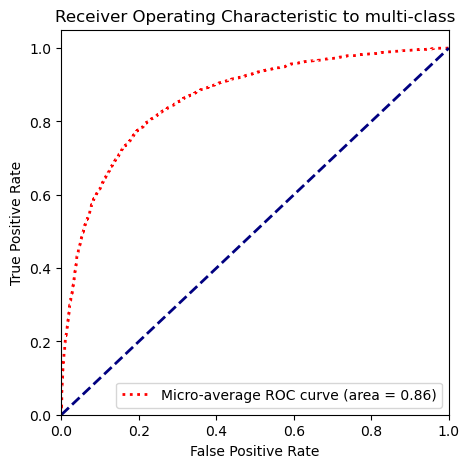

Average ROC AUC score: 0.86


In [13]:
def plot_multilabel_roc(y_test, prediction_probs):
    n_classes = y_test.shape[1]
    fig, ax = plt.subplots(figsize=(5, 5))

    prediction_probs_combined = np.vstack([probs[:, 1] for probs in prediction_probs]).T

    roc_auc_list = []
    for i in range(n_classes):
        fpr, tpr, thresholds = roc_curve(y_test.iloc[:, i], prediction_probs_combined[:, i])
        roc_auc = auc(fpr, tpr)
        roc_auc_list.append(roc_auc)
#         ax.plot(fpr, tpr, lw=2, label=f'ROC curve of class {i} (area = {roc_auc:.2f})')

    fpr, tpr, _ = roc_curve(y_test.to_numpy().ravel(), prediction_probs_combined.ravel())
    roc_auc = auc(fpr, tpr)

    ax.plot(fpr, tpr, color='red', lw=2, linestyle=':', label=f'Micro-average ROC curve (area = {roc_auc:.2f})')

    ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

    ax.set(xlim=[0.0, 1.0], ylim=[0.0, 1.05], title="Receiver Operating Characteristic to multi-class")
    ax.legend(loc="lower right")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show()
    
    average_roc_auc = np.mean(roc_auc_list)
    print(f'Average ROC AUC score: {roc_auc:.2f}')
plot_multilabel_roc(y_test, prediction_probs)

##### observations:
- With fine tunining xgboost on our reduced data-set we are getting roc_auc_score of 0.86.
- From the previous phase we saw that when we used all the features where we one-hot-encoded these features we were getting 0.87 so there is not any significant reduction in the accuracy.

##### Training Logistic Model
- We went ahead with LogisticRegression model. In the previous phase we tried out several models and we decided to fine tune each and check the accuacy on the test data set.

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier

# Create a logistic regression model
logistic_model = LogisticRegression()

# Wrap it in a MultiOutputClassifier for multi-label classification
multioutput_model3 = MultiOutputClassifier(logistic_model)

# Fit the model to your data
multioutput_model3.fit(X_train, y_train)  # X_train is your input features, y_train is the multilabel target

# Now multioutput_model is your trained model

MultiOutputClassifier(estimator=LogisticRegression())

In [10]:
prediction_probs = multioutput_model3.predict_proba(X_test)


##### Evaluation Metrics:
- As discussed in the previous phase we took roc-auc score as our evaluation metric as it is a good indicator how model is doing on test data for a multilabel classification problem


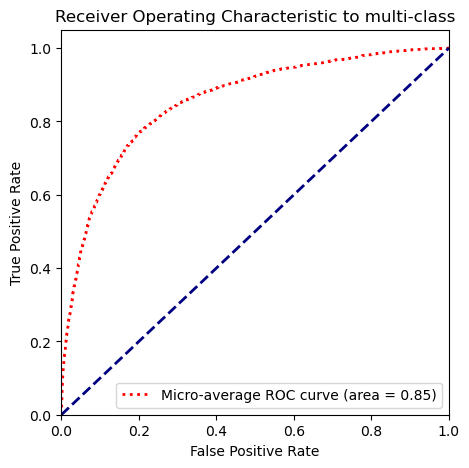

Average ROC AUC score: 0.85


In [11]:
def plot_multilabel_roc(y_test, prediction_probs):
    n_classes = y_test.shape[1]
    fig, ax = plt.subplots(figsize=(5, 5))

    prediction_probs_combined = np.vstack([probs[:, 1] for probs in prediction_probs]).T

    roc_auc_list = []
    for i in range(n_classes):
        fpr, tpr, thresholds = roc_curve(y_test.iloc[:, i], prediction_probs_combined[:, i])
        roc_auc = auc(fpr, tpr)
        roc_auc_list.append(roc_auc)
#         ax.plot(fpr, tpr, lw=2, label=f'ROC curve of class {i} (area = {roc_auc:.2f})')

    fpr, tpr, _ = roc_curve(y_test.to_numpy().ravel(), prediction_probs_combined.ravel())
    roc_auc = auc(fpr, tpr)

    ax.plot(fpr, tpr, color='red', lw=2, linestyle=':', label=f'Micro-average ROC curve (area = {roc_auc:.2f})')

    ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

    ax.set(xlim=[0.0, 1.0], ylim=[0.0, 1.05], title="Receiver Operating Characteristic to multi-class")
    ax.legend(loc="lower right")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show()
    
    average_roc_auc = np.mean(roc_auc_list)
    print(f'Average ROC AUC score: {roc_auc:.2f}')
plot_multilabel_roc(y_test, prediction_probs)

##### Observation:
- As we can see we are getting roc auc score of 85 which is good and we can go ahead and use this model in production as it is both faster as well as efficient.

##### create the .pkl file

In [ ]:
import joblib
joblib.dump(multioutput_model3, 'multioutput_model3.pkl')